In [1]:
%matplotlib inline
from matplotlib import style
style.use(["dark_background", "seaborn-poster"])

# Bathymetry

In [2]:
import pandas as pd
from oceans.datasets import get_depth


df = pd.DataFrame(
    data=[[-40, -20], [-32, -20]],
    columns=["lon", "lat"],
)

df["depth"] = get_depth(df["lon"], df["lat"])
df

,lon,lat,depth
0,-40,-20,-32.988164
1,-32,-20,-4275.633746


In [3]:
from oceans.datasets import etopo_subset, get_isobath


bbox = [-43, -30, -22, -17]

segments = get_isobath(bbox=bbox, iso=-200, smoo=True)
lon, lat, bathy = etopo_subset(bbox=bbox, smoo=True)

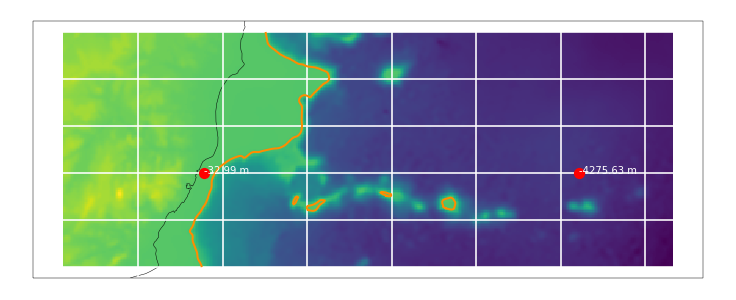

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


fig, ax = plt.subplots(
    figsize=(12, 12),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.plot(df["lon"], df["lat"], "ro")
for k, row in df.iterrows():
    ax.text(row["lon"], row["lat"], f"{row['depth']:.2f} m", color="white")

cs = ax.pcolormesh(lon, lat, bathy)
for segment in segments:
    lines = ax.plot(segment[:, 0], segment[:, -1], "darkorange", linewidth=2)

ax.coastlines("10m")
ax.gridlines(draw_labels=True, );

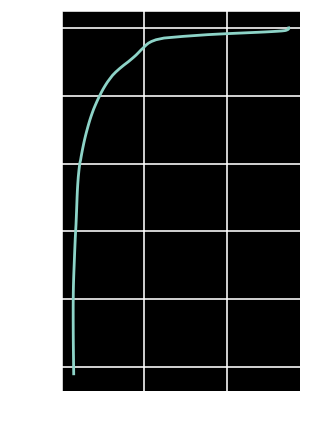

In [5]:
from oceans.datasets import woa_profile


cube = woa_profile(-143, 10, variable="temperature", time_period="annual", resolution="5")

fig, ax = plt.subplots(figsize=(4.25, 7))
z = cube.coord(axis="Z").points
l = ax.plot(cube[0, :].data, z)
ax.grid(True)
ax.invert_yaxis()

# Extract a 2D surface -- Annual temperature climatology

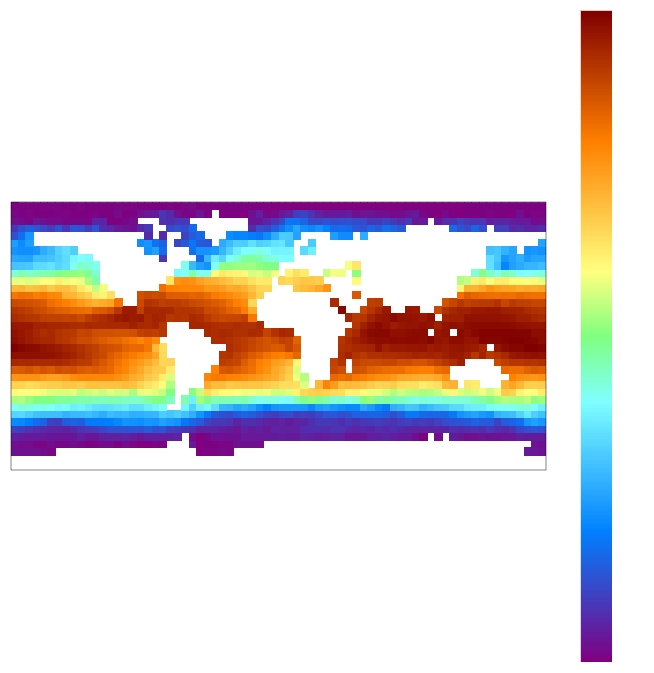

In [6]:
import iris.plot as iplt
from oceans.datasets import woa_subset
from oceans.colormaps import cm


bbox = [2.5, 357.5, -87.5, 87.5]
cube = woa_subset(bbox, variable="temperature", time_period="annual", resolution="5")
c = cube[0, 0, ...]  # Slice singleton time and first level.

fig, ax = plt.subplots(figsize=(12, 12))

cs = iplt.pcolormesh(c, cmap=cm.avhrr)
cbar = plt.colorbar(cs)

# Extract a square around the Mariana Trench averaging into a profile

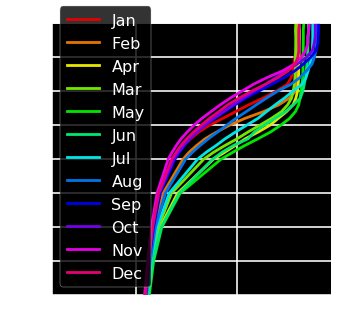

In [7]:
import warnings
import iris
from oceans.colormaps import get_color


months = "Jan Feb Apr Mar May Jun Jul Aug Sep Oct Nov Dec".split()
colors = get_color(len(months))
bbox = [-143, -141, 10, 12]

fig, ax = plt.subplots(figsize=(5, 5))

for month in months:
    cube = woa_subset(bbox, time_period=month, variable="temperature", resolution="1")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_areas = iris.analysis.cartography.area_weights(cube)
        c = cube.collapsed(["longitude", "latitude"], iris.analysis.MEAN, weights=grid_areas)
    z = c.coord(axis="Z").points
    l = ax.plot(c[0, :].data, z, label=month, color=next(colors))

ax.grid(True)
ax.invert_yaxis()
leg = ax.legend(loc="lower left")
ax.set_ylim(200, 0);